# Step 1 : Importing Essetial Libraries

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# Step 2 : Importing Data and Creating a Dataframe

In [18]:
import os
import pandas as pd

train_dir = 'Data/Train'
test_dir = 'Data/Test'

# Create lists to store data
train_data = []
test_data = []

# Add images paths and labels to lists
for label, directory in enumerate(os.listdir(train_dir)):
    for filename in os.listdir(os.path.join(train_dir, directory)):
        image_path = os.path.join(train_dir, directory, filename)
        train_data.append({'image_path': image_path, 'label': label})

for label, directory in enumerate(os.listdir(test_dir)):
    for filename in os.listdir(os.path.join(test_dir, directory)):
        image_path = os.path.join(test_dir, directory, filename)
        test_data.append({'image_path': image_path, 'label': label})

# Create DataFrames from lists of dictionaries
train_df = pd.DataFrame.from_records(train_data)
test_df = pd.DataFrame.from_records(test_data)

# Combine train_df and test_df into one DataFrame
df = pd.concat([train_df, test_df], ignore_index=True)
df

,image_path,label
0,Data/Train\actinic keratosis\ISIC_0025780.jpg,0
1,Data/Train\actinic keratosis\ISIC_0025803.jpg,0
2,Data/Train\actinic keratosis\ISIC_0025825.jpg,0
3,Data/Train\actinic keratosis\ISIC_0025953.jpg,0
4,Data/Train\actinic keratosis\ISIC_0025957.jpg,0
...,...,...
2352,Data/Test\squamous cell carcinoma\ISIC_0024575...,7
2353,Data/Test\squamous cell carcinoma\ISIC_0024579...,7
2354,Data/Test\vascular lesion\ISIC_0024370.jpg,8
2355,Data/Test\vascular lesion\ISIC_0024375.jpg,8


In [19]:
# Get list of directories in train_dir
labels = os.listdir(train_dir)

# Create label_map dictionary
label_map = {i: label for i, label in enumerate(labels)}
num_classes=len(label_map)
label_map

{0: 'actinic keratosis',
 1: 'basal cell carcinoma',
 2: 'dermatofibroma',
 3: 'melanoma',
 4: 'nevus',
 5: 'pigmented benign keratosis',
 6: 'seborrheic keratosis',
 7: 'squamous cell carcinoma',
 8: 'vascular lesion'}

# Step 3 : EDA

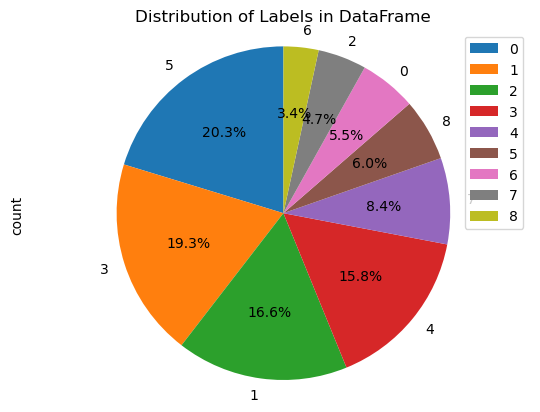

In [20]:
# Plot pie chart of train_df
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Labels in DataFrame')
plt.legend(df['label'].unique())
plt.show()

In [21]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               actinic keratosis              130       
1               basal cell carcinoma           392       
2               dermatofibroma                 111       
3               melanoma                       454       
4               nevus                          373       
5               pigmented benign keratosis     478       
6               seborrheic keratosis           80        
7               squamous cell carcinoma        197       
8               vascular lesion                142       
------------------------------------------------------------
Total                                         2357      


# Step 4 : Loading and resizing of images

In [22]:
max_images_per_class = 2500

# Group by label column and take first max_images_per_class rows for each group
df = df.groupby("label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)

In [23]:
import tensorflow as tf

# Allow gpu usage
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [24]:
import multiprocessing

# Get the number of CPU cores available
max_workers = multiprocessing.cpu_count()
max_workers

16

In [25]:
import concurrent.futures

# Define a function to resize image arrays
def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).resize((100,75)))

# Use concurrent.futures to parallelize the resizing process
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Use executor.map to apply the function to each image path in the DataFrame
    image_arrays = list(executor.map(resize_image_array, df['image_path'].tolist()))

# Add the resized image arrays to the DataFrame
df['image'] = image_arrays
del image_arrays

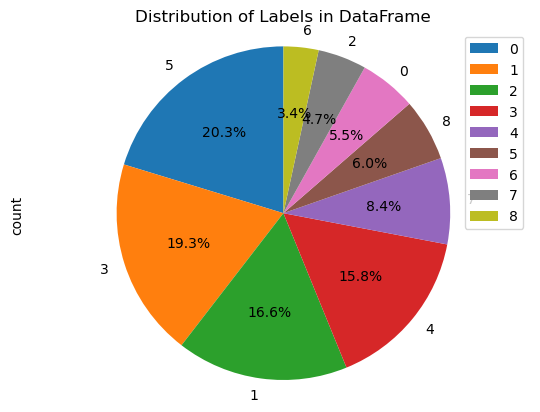

In [26]:
# Plot pie chart of train_df
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Labels in DataFrame')
plt.legend(df['label'].unique())
plt.show()

In [27]:
df.head()

,image_path,label,image
0,Data/Train\actinic keratosis\ISIC_0025780.jpg,0,"[[[139, 79, 87], [138, 77, 84], [128, 63, 65],..."
1,Data/Train\actinic keratosis\ISIC_0025803.jpg,0,"[[[114, 85, 85], [96, 66, 60], [86, 64, 69], [..."
2,Data/Train\actinic keratosis\ISIC_0025825.jpg,0,"[[[166, 120, 116], [170, 126, 122], [175, 132,..."
3,Data/Train\actinic keratosis\ISIC_0025953.jpg,0,"[[[168, 91, 91], [179, 103, 102], [185, 112, 1..."
4,Data/Train\actinic keratosis\ISIC_0025957.jpg,0,"[[[206, 155, 156], [206, 156, 157], [211, 164,..."


> # Displaying the total number of images of each Class before Data Augmentation

In [28]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               actinic keratosis              130       
1               basal cell carcinoma           392       
2               dermatofibroma                 111       
3               melanoma                       454       
4               nevus                          373       
5               pigmented benign keratosis     478       
6               seborrheic keratosis           80        
7               squamous cell carcinoma        197       
8               vascular lesion                142       
------------------------------------------------------------
Total                                         2357      


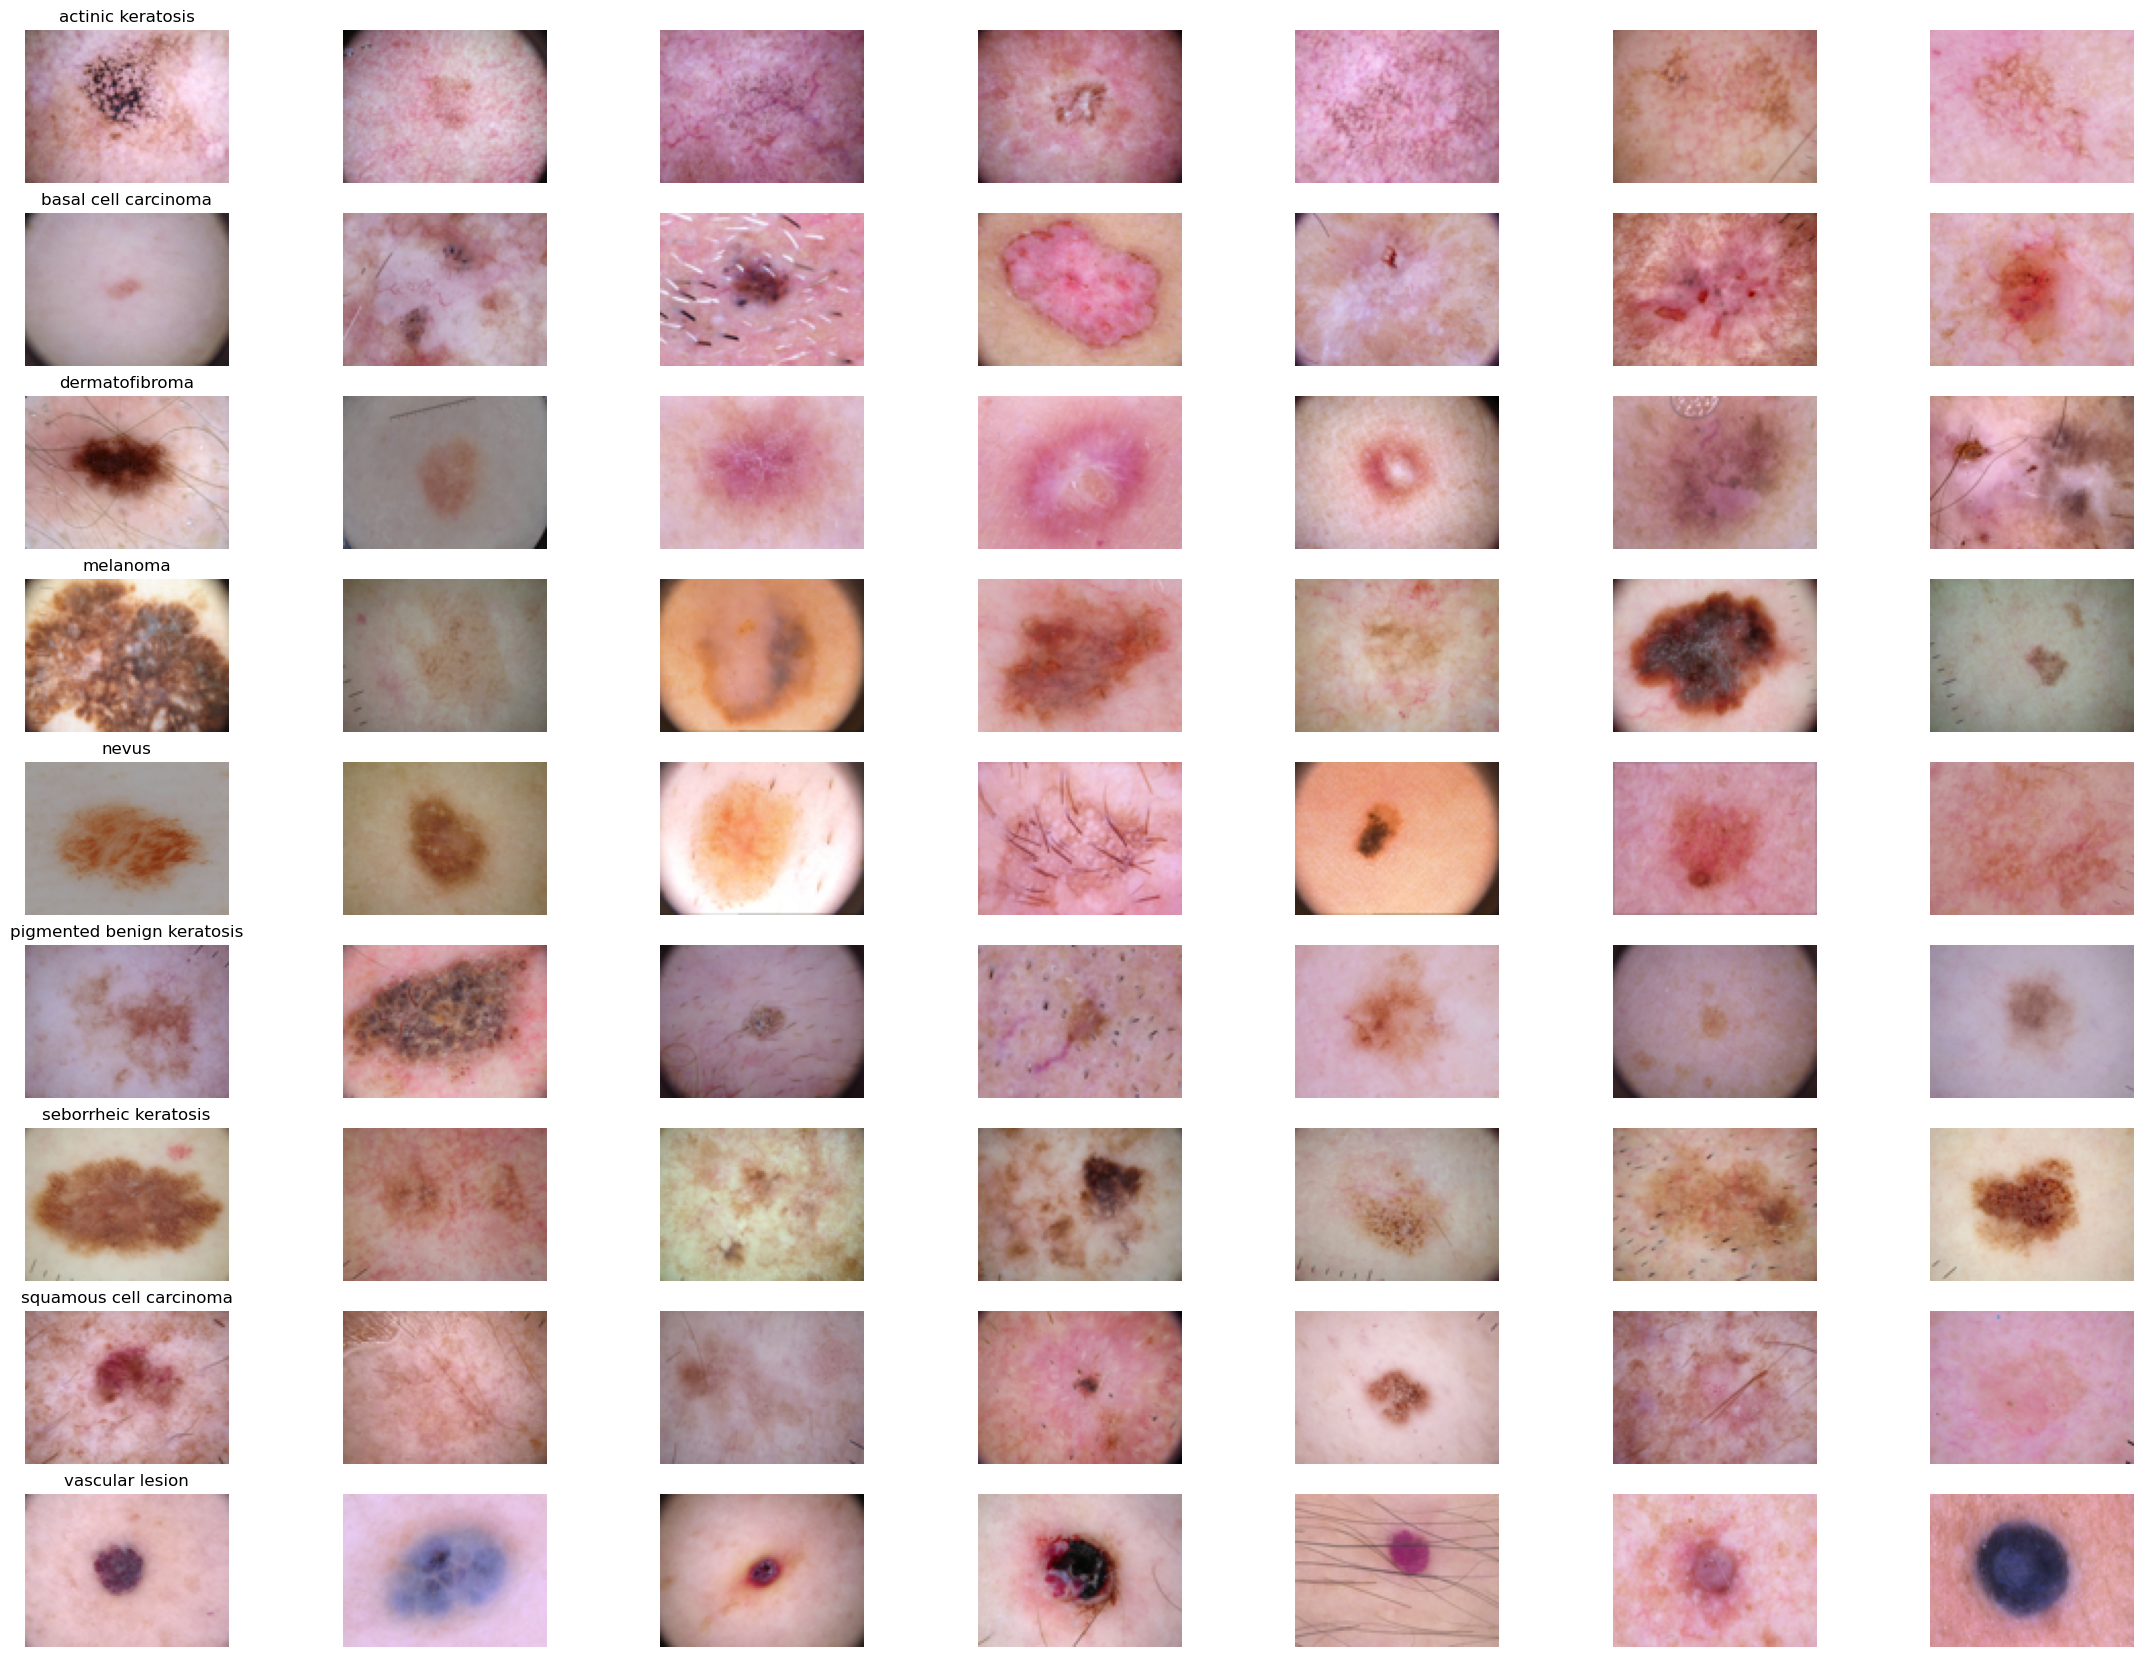

In [29]:
n_samples = 7
fig, m_axs = plt.subplots(num_classes, n_samples, figsize=(4*n_samples, 3*7))
for n_axs, (class_idx, class_rows) in zip(m_axs, df.sort_values(['label']).groupby('label')):
    class_name = label_map[class_idx] # get the class name using label_map
    n_axs[0].set_title(class_name)
    for c_ax, (_, c_row) in zip(n_axs, class_rows.sample(n_samples, random_state=5).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [30]:
df['image'].map(lambda x: x.shape).value_counts()

image
(75, 100, 3)    2357
Name: count, dtype: int64

# Step 5 : Data Augmentation

In [31]:
from keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator object with the desired transformations
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [33]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming you have already defined max_images_per_class and datagen earlier.

# Create an empty dataframe to store the augmented images
augmented_df = pd.DataFrame(columns=['image_path', 'label', 'image'])

# Loop through each class label and generate additional images if needed
for class_label in df['label'].unique():
    # Get the image arrays for the current class
    image_arrays = df.loc[df['label'] == class_label, 'image'].values
    
    # Calculate the number of additional images needed for the current class
    num_images_needed = max_images_per_class - len(image_arrays)
    
    # Generate augmented images for the current class
    if num_images_needed > 0:
        # Select a random subset of the original images
        selected_images = np.random.choice(image_arrays, size=num_images_needed)
        
        # Apply transformations to the selected images and add them to the augmented dataframe
        for image_array in selected_images:
            # Reshape the image array to a 4D tensor with a batch size of 1
            image_tensor = np.expand_dims(image_array, axis=0)
            
            # Generate the augmented images
            augmented_images = datagen.flow(image_tensor, batch_size=1)
            
            # Extract the augmented image arrays and add them to the augmented dataframe
            for i in range(augmented_images.n):
                augmented_image_array = augmented_images.next()[0].astype('uint8')
                augmented_df = pd.concat([augmented_df, pd.DataFrame({'image_path': [None], 'label': [class_label], 'image': [augmented_image_array]})], ignore_index=True)
    
    # Add the original images for the current class to the augmented dataframe
    original_images_df = df.loc[df['label'] == class_label, ['image_path', 'label', 'image']]
    augmented_df = pd.concat([augmented_df, original_images_df], ignore_index=True)

# Group the augmented dataframe by the 'label' column and filter out extra images
df = augmented_df.groupby('label').head(max_images_per_class)

del augmented_df

# Use the augmented dataframe for further processing
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


> # Displaying the total number of images of each Class after Data Augmentation

In [34]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               actinic keratosis              2500      
1               basal cell carcinoma           2500      
2               dermatofibroma                 2500      
3               melanoma                       2500      
4               nevus                          2500      
5               pigmented benign keratosis     2500      
6               seborrheic keratosis           2500      
7               squamous cell carcinoma        2500      
8               vascular lesion                2500      
------------------------------------------------------------
Total                                         22500     


# Step 6 : Train and Test split

In [35]:
features = df.drop(columns=['label','image_path'],axis=1)
target = df['label']

In [36]:
features.head()

,image
0,"[[[202, 147, 145], [202, 147, 144], [202, 146,..."
1,"[[[150, 112, 105], [150, 112, 105], [150, 112,..."
2,"[[[4, 2, 5], [6, 4, 12], [27, 17, 26], [54, 30..."
3,"[[[213, 218, 201], [214, 219, 202], [215, 219,..."
4,"[[[193, 149, 154], [194, 149, 155], [197, 154,..."


In [37]:
target.head()

0    0
1    3
2    7
3    3
4    4
Name: label, dtype: object

In [38]:
print(target.shape,features.shape)

(22500,) (22500, 1)


In [39]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20,shuffle=True)

# Step 7 : Normalization of Data

In [40]:
x_train = np.asarray(x_train['image'].tolist())
x_test = np.asarray(x_test['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

# Step 8 : Label Encoding

In [41]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train,num_classes = num_classes)
y_test = to_categorical(y_test,num_classes = num_classes)

# Step 9 : Splitting the data into training and Validation Split

In [42]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2,shuffle=True)

In [43]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [44]:
y_train = y_train.astype(int)
y_validate = y_validate.astype(int)

> # Displaying the total number of images of each Class

In [45]:
# Calculate the number of images in each class for train, validation, and test datasets
train_counts = np.sum(y_train, axis=0)
val_counts = np.sum(y_validate, axis=0)
test_counts = np.sum(y_test, axis=0)

# Print the number of images in each class for train, validation, and test datasets
print("Dataset Summary")
print("-" * 90)
print(f"{'Class Label':<15} {'Class Name':<30} {'Train':<10} {'Validation':<12} {'Test':<10} {'Total':<10}")
print("-" * 90)
for class_label, class_name in label_map.items():
    train_num = int(train_counts[class_label])
    val_num = int(val_counts[class_label])
    test_num = int(test_counts[class_label])
    total_num = train_num + val_num + test_num
    print(f"{class_label:<15} {class_name:<30} {train_num:<10} {val_num:<12} {test_num:<10} {total_num:<10}")
print("-" * 90)
print(f"{'Total':<46} {len(y_train):<10} {len(y_validate):<12} {len(y_test):<10} {len(y_train) + len(y_validate) + len(y_test):<10}")

Dataset Summary
------------------------------------------------------------------------------------------
Class Label     Class Name                     Train      Validation   Test       Total     
------------------------------------------------------------------------------------------
0               actinic keratosis              1623       378          499        2500      
1               basal cell carcinoma           1624       396          480        2500      
2               dermatofibroma                 1582       397          521        2500      
3               melanoma                       1616       375          509        2500      
4               nevus                          1614       411          475        2500      
5               pigmented benign keratosis     1605       385          510        2500      
6               seborrheic keratosis           1575       445          480        2500      
7               squamous cell carcinoma        1591       

In [46]:
df.groupby('label').size()

label
0    2500
1    2500
2    2500
3    2500
4    2500
5    2500
6    2500
7    2500
8    2500
dtype: int64

In [47]:
input_shape = df['image'][0].shape

# Step 10 : Model Architecture

In [48]:
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

# DenseNet201
model = Sequential()
model.add(DenseNet201(include_top=False, weights='imagenet', input_shape=input_shape))
model.add(Flatten())
model.add(Dropout(0.5))  # Add a Dropout layer with a dropout rate of 0.5
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

74836368/74836368 [==============================] - 8s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 2, 3, 1920)        18321984  
                                                                 
 flatten (Flatten)           (None, 11520)             0         
                                                                 
 dropout (Dropout)           (None, 11520)             0         
                                                                 
 dense (Dense)               (None, 512)               5898752   
                                                                 
 dense_1 (Dense)             (None, 9)                 4617      
                                                                 
Total params: 24,225,353
Trainable params: 23,996,297
Non-trainable params: 229,056
_______________________________________

# Step 11 : Setting Optimizer

In [49]:
# compile model
from keras.optimizers import SGD
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

# Step 12: Fitting of model

In [53]:
import gc
gc.collect()

1860

In [54]:
# Fit the model
epochs = 50
batch_size=32
history = model.fit(x=x_train,
                    y=y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_validate,y_validate),
                    callbacks=learning_rate_reduction)

Epoch 1/50
450/450 [==============================] - 188s 419ms/step - loss: 0.2765 - accuracy: 0.8928 - val_loss: 0.3821 - val_accuracy: 0.8689 - lr: 0.0010
Epoch 2/50
450/450 [==============================] - 188s 419ms/step - loss: 0.2146 - accuracy: 0.9174 - val_loss: 0.3335 - val_accuracy: 0.8889 - lr: 0.0010
Epoch 3/50
450/450 [==============================] - 174s 388ms/step - loss: 0.1835 - accuracy: 0.9282 - val_loss: 0.3511 - val_accuracy: 0.8831 - lr: 0.0010
Epoch 4/50
450/450 [==============================] - 187s 415ms/step - loss: 0.1462 - accuracy: 0.9435 - val_loss: 0.3466 - val_accuracy: 0.8867 - lr: 0.0010
Epoch 5/50
450/450 [==============================] - 212s 470ms/step - loss: 0.1323 - accuracy: 0.9500 - val_loss: 0.3656 - val_accuracy: 0.8892 - lr: 0.0010
Epoch 6/50
450/450 [==============================] - 223s 496ms/step - loss: 0.1021 - accuracy: 0.9611 - val_loss: 0.4060 - val_accuracy: 0.8928 - lr: 0.0010
Epoch 7/50
450/450 [==========================

450/450 [==============================] - 214s 476ms/step - loss: 0.0356 - accuracy: 0.9856 - val_loss: 0.5984 - val_accuracy: 0.8839 - lr: 0.0010
Epoch 22/50
450/450 [==============================] - 194s 432ms/step - loss: 0.0335 - accuracy: 0.9858 - val_loss: 0.5223 - val_accuracy: 0.9006 - lr: 0.0010
Epoch 23/50
450/450 [==============================] - 193s 427ms/step - loss: 0.0377 - accuracy: 0.9842 - val_loss: 0.5228 - val_accuracy: 0.8892 - lr: 0.0010
Epoch 24/50
450/450 [==============================] - 222s 494ms/step - loss: 0.0270 - accuracy: 0.9890 - val_loss: 0.5355 - val_accuracy: 0.8953 - lr: 0.0010
Epoch 25/50
450/450 [==============================] - 195s 430ms/step - loss: 0.0219 - accuracy: 0.9901 - val_loss: 0.5702 - val_accuracy: 0.9028 - lr: 0.0010
Epoch 26/50
450/450 [==============================] - 183s 407ms/step - loss: 0.0221 - accuracy: 0.9899 - val_loss: 0.5325 - val_accuracy: 0.9075 - lr: 0.0010
Epoch 27/50
450/450 [==============================]

450/450 [==============================] - 214s 477ms/step - loss: 0.0225 - accuracy: 0.9912 - val_loss: 0.5727 - val_accuracy: 0.8994 - lr: 0.0010
Epoch 42/50
450/450 [==============================] - 212s 473ms/step - loss: 0.0269 - accuracy: 0.9885 - val_loss: 0.5603 - val_accuracy: 0.9039 - lr: 0.0010
Epoch 43/50
450/450 [==============================] - 209s 465ms/step - loss: 0.0219 - accuracy: 0.9897 - val_loss: 0.5646 - val_accuracy: 0.9050 - lr: 0.0010
Epoch 44/50
450/450 [==============================] - 202s 449ms/step - loss: 0.0170 - accuracy: 0.9916 - val_loss: 0.6364 - val_accuracy: 0.9036 - lr: 0.0010
Epoch 45/50
450/450 [==============================] - 187s 417ms/step - loss: 0.0192 - accuracy: 0.9906 - val_loss: 0.5922 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 46/50
450/450 [==============================] - 204s 454ms/step - loss: 0.0213 - accuracy: 0.9908 - val_loss: 0.6014 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 47/50
450/450 [==============================]

# Step 13 : Model Evaluation

In [56]:
gc.collect()

1284

In [57]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=1)
print("Train: accuracy = %f  ;  loss = %f" % (accuracy, loss))

450/450 [==============================] - 58s 128ms/step - loss: 0.0082 - accuracy: 0.9949
Train: accuracy = 0.994861  ;  loss = 0.008169


In [58]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Testing: accuracy = %f  ;  loss = %f" % (accuracy, loss))

141/141 [==============================] - 20s 124ms/step - loss: 0.5039 - accuracy: 0.9176
Testing: accuracy = 0.917556  ;  loss = 0.503882


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predicted probabilities for the test set
y_pred_prob = model.predict(x_test)

# Find the class with the highest probability for each sample
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Plot the confusion matrix using Seaborn
sns.heatmap(cm, annot=True, cmap='Blues')

 62/141 [============>.................] - ETA: 9s 

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

# Calculate evaluation metrics
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
precision = precision_score(np.argmax(y_test, axis=1), y_pred, average='macro')
recall = recall_score(np.argmax(y_test, axis=1), y_pred, average='macro')
f1 = f1_score(np.argmax(y_test, axis=1), y_pred, average='macro')
kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Kappa score: {kappa:.4f}")

# Step 14 : Saving the model

In [ ]:
model.save("Model/skinDiseaseDetection.h5")